In [3]:
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import pygalmesh
import fenics as fe
import torch

import sys
sys.path.append('..')
import project

<IPython.core.display.Javascript object>


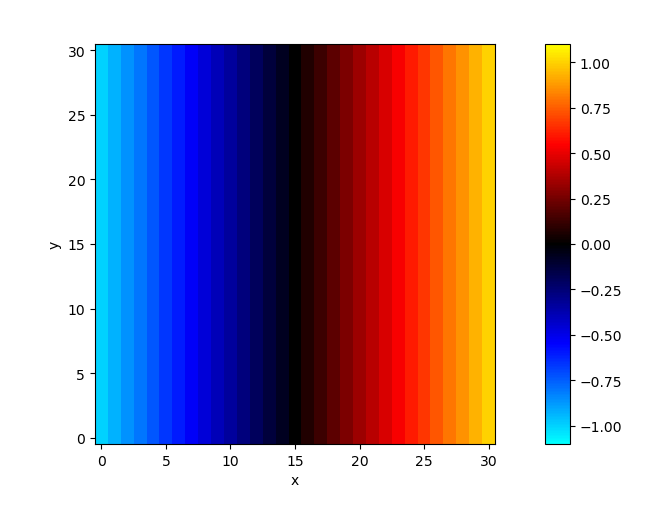

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

<IPython.core.display.Javascript object>


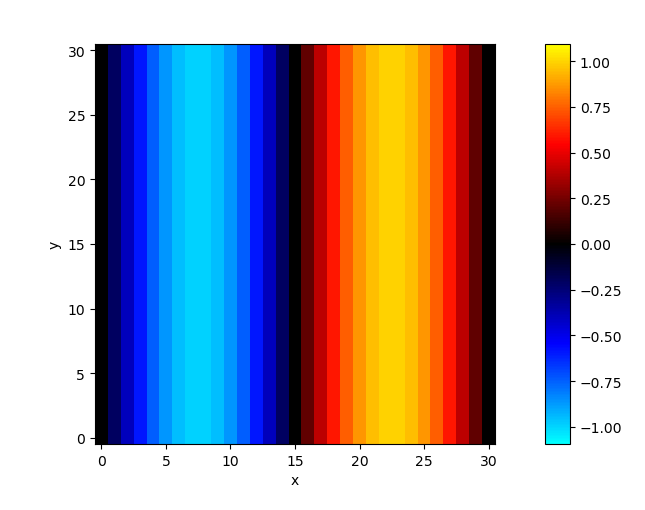

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [76]:
%autoreload

shape = (31, 31, 31)
resolution = (1, 1, 1)

disp_x = np.linspace(-1, 1, shape[0])
disp_y = np.linspace(-1, 1, shape[1])
disp_z = np.linspace(-1, 1, shape[2])

disp = xr.DataArray(
    data=np.stack(np.meshgrid(disp_x, disp_y, disp_z, indexing='ij'), axis=-1),
    dims=['x', 'y', 'z', 'component'],
    coords={
        'x': np.arange(shape[0]) * resolution[0], 
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
        'component': ['x', 'y', 'z']
    }
)
disp.name = 'displacement'

disp2 = np.sin(disp * 2 * np.pi / 2)

project.visual.XArrayViewer(disp, x='x', y='y')
project.visual.XArrayViewer(disp2, x='x', y='y')

<IPython.core.display.Javascript object>


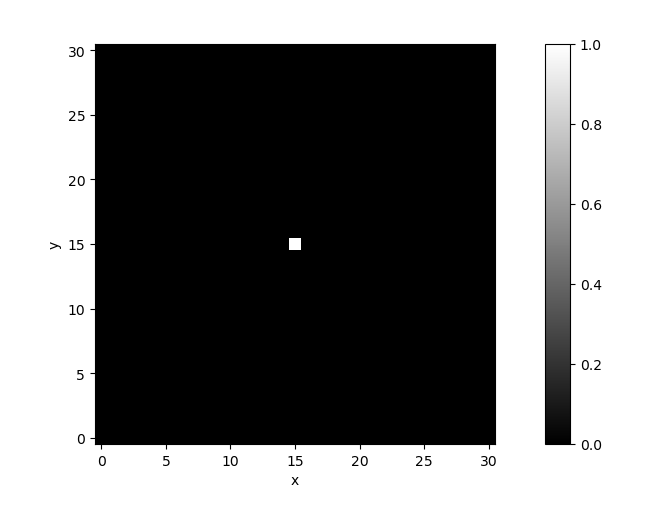

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [77]:
mask = ((disp**2).sum('component') <= 1).astype(np.uint8)
mask.name = 'mask'

project.visual.XArrayViewer(mask)

In [80]:
mesh = pygalmesh.generate_from_array(mask.values, voxel_size=[1,1,1], max_cell_circumradius=2.0, odt=True)

vertices = mesh.points
facets = mesh.cells[0].data
tetras = mesh.cells[1].data

angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)

vertices.shape, facets.shape, tetras.shape

((1512, 3), (2364, 3), (7196, 4))

<IPython.core.display.Javascript object>


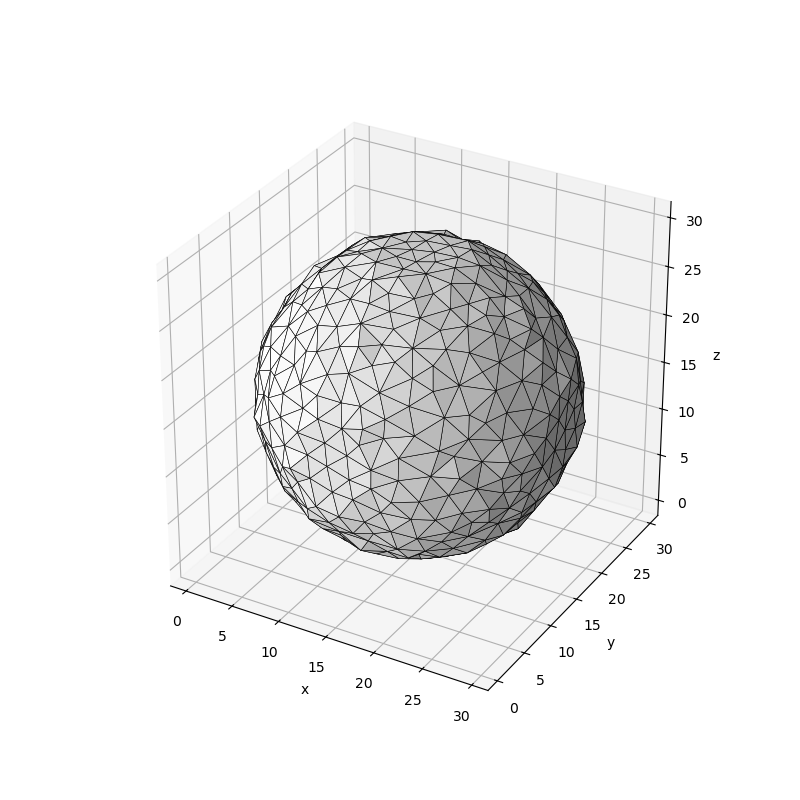

In [81]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
#ax.grid(False)
#ax.xaxis.set_pane_color((1,1,1,0))
#ax.yaxis.set_pane_color((1,1,1,0))
#ax.zaxis.set_pane_color((1,1,1,0))
#ax.set_axis_off()

In [82]:
import meshio
from mpi4py import MPI

def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

fe_mesh = convert_to_fe_mesh(mesh.points, mesh.cells[1])

In [90]:
%%time
import torch
import torch.nn.functional as F

# functions for converting between image-like arrays 
#   and vectors of coefficients for a linear FEM basis

def image_to_dofs(image, resolution, V):
    '''
    Args:
        image: (n_x, n_y, n_z, n_c) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
    Returns:
        dofs: (batch_size, mesh_size, n_channels) torch.Tensor
    '''
    n_x, n_y, n_z, n_c = image.shape
    
    dof_coords = V.tabulate_dof_coordinates()
    dof_coords = dof_coords[::V.num_sub_spaces(),:]
    
    mesh_size, n_dims = dof_coords.shape

    dof_coords = torch.as_tensor(dof_coords, dtype=image.dtype, device=image.device)

    shape = torch.as_tensor([n_x, n_y, n_z], dtype=image.dtype, device=image.device)
    resolution = torch.as_tensor(resolution, dtype=image.dtype, device=image.device)
    extent = (shape - 1) * resolution

    dofs = F.grid_sample(
        input=image[None,...].permute(0,4,3,2,1), # xyzc -> bczyx
        grid=(dof_coords[None,None,None,...] / extent) * 2 - 1,
        align_corners=True
    )
    return dofs.view(n_c, mesh_size).permute(1,0)


u_tensor = torch.as_tensor(disp2.values)
u_func_space = fe.VectorFunctionSpace(fe_mesh, 'P', 1)
u_func_dofs = image_to_dofs(u_tensor, resolution, u_func_space)

CPU times: user 8.08 ms, sys: 88 µs, total: 8.17 ms
Wall time: 7.65 ms


In [84]:
import torch_fenics

u_func = torch_fenics.numpy_fenics.numpy_to_fenics(
    u_func_dofs.detach().cpu().numpy(), fe.Function(u_func_space)
)
u_func.set_allow_extrapolation(True)

In [85]:
u_func([0,0,0])

array([-1.23194218, -0.45251409, -0.61259494])

In [86]:
u_func([(shape[0] - 1) * resolution[0],0,0])

array([ 0.74129557, -0.67903825, -1.03031017])

In [87]:
u_func([0,(shape[1] - 1) * resolution[1],0])

array([-0.61817052,  1.07286063, -0.5977812 ])

In [88]:
u_func([0,0,(shape[2] - 1) * resolution[2]])

array([-0.80386289, -0.40402231,  1.04579087])

In [91]:
%%time
import torch_fenics

def dofs_to_image(dofs, V, image_shape, resolution):
    '''
    Args:
        dofs: (mesh_size, n_c) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
        image_shape: (int, int, int) tuple
    Returns:
        image: (n_x, n_y, n_z, n_c) torch.Tensor
    '''
    mesh_size, n_c = dofs.shape
    n_x, n_y, n_z = image_shape

    x = np.arange(n_x) * resolution[0]
    y = np.arange(n_y) * resolution[1]
    z = np.arange(n_z) * resolution[2]

    grid = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)
    print(image_shape, grid.shape)

    func = torch_fenics.numpy_fenics.numpy_to_fenics(
        dofs.detach().cpu().numpy(), fe.Function(V)
    )
    func.set_allow_extrapolation(True)

    image = np.zeros((n_x, n_y, n_z, n_c))
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                func.eval(image[i,j,k], grid[i,j,k])

    return image

u_interp = dofs_to_image(u_func_dofs, u_func_space, shape, resolution)

(31, 31, 31) (31, 31, 31, 3)
CPU times: user 563 ms, sys: 47.1 ms, total: 610 ms
Wall time: 548 ms


<IPython.core.display.Javascript object>


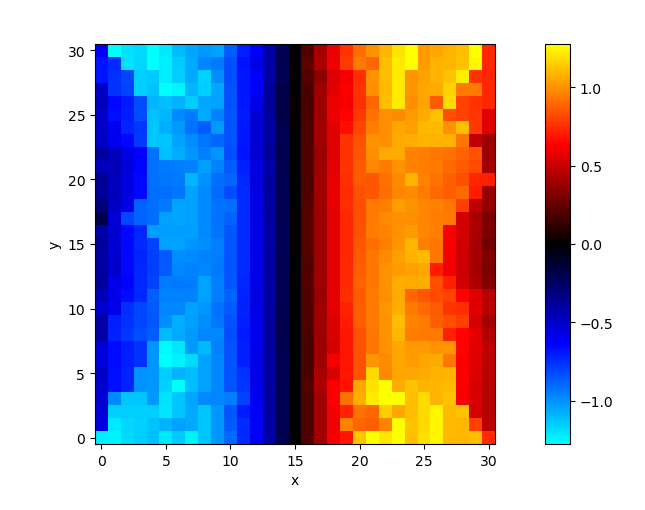

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [93]:
project.visual.XArrayViewer(disp * 0 + u_interp)